<a href="https://colab.research.google.com/github/michelucci/oreilly-london-ai/blob/master/day1/MNIST_Classification_with_eager_execution_in_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Classification with eager execution in Keras

(C) 2019 Umberto Michelucci

umberto.michelucci@toelt.ai

www.toelt.ai

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import tensorflow.contrib.eager as tfe

from google.colab import files

tf.enable_eager_execution()

Using TensorFlow backend.


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



let's load the MNIST dataset first

In [2]:
num_classes = 10

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_vector_size = 28*28
x_train = x_train.reshape(x_train.shape[0], image_vector_size)
x_test = x_test.reshape(x_test.shape[0], image_vector_size)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step


Now let's convert our data in a dataset, to make our training easier.

In [0]:
dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(x_train/255.0, tf.float32),
     tf.cast(y_train,tf.int64)))

dataset = dataset.shuffle(60000).batch(64)

In [0]:
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Dense(1024, input_shape=(784,)),  # must declare input shape
  tf.keras.layers.Dense(1024),  # must declare input shape
  tf.keras.layers.Dense(10)
])

We can check the results for one single image easily with the dataset

In [5]:
for image,labels in dataset.take(1):
  print(image.shape)
  print(labels[0:1])
  print("Logits: ", mnist_model(image[0:1]).numpy())
  print('label ',tf.argmax(labels[0:1], axis = 1)) 
  # Check how, since we are using eager execution
  # we don't need a session to evaluate the node
  print(tf.argmax(tf.nn.softmax(mnist_model(image[0:1])), axis = 1))
  # Of course the prediction are not right, since we have not yet
  # trianed the model.

(64, 784)
tf.Tensor([[0 0 0 0 0 0 0 0 0 1]], shape=(1, 10), dtype=int64)
Logits:  [[-0.07571369  0.42217183 -0.0248108  -0.48363817  0.20608075  0.12230226
   0.8848293  -0.2542535  -0.28345734 -0.40715685]]
label  tf.Tensor([9], shape=(1,), dtype=int64)
tf.Tensor([6], shape=(1,), dtype=int64)


In [0]:
optimizer = tf.train.AdamOptimizer()
loss_history = []

In [7]:
%%time
with tf.device('/cpu:0'):
  for i in range(10): # Loop for the Epochs
    print ("\nEpoch:", i)
    for (batch, (images, labels)) in enumerate(dataset.take(60000)): # Loop for the mini-batches
      if batch % 100 == 0:
        print('.', end='')
      with tf.GradientTape() as tape:
        logits = mnist_model(images, training=True)
        loss_value = tf.losses.sparse_softmax_cross_entropy(tf.argmax(labels, axis = 1), logits)

        loss_history.append(loss_value.numpy())
        grads = tape.gradient(loss_value, mnist_model.variables)
        optimizer.apply_gradients(zip(grads, mnist_model.variables),
                                  global_step=tf.train.get_or_create_global_step())


Epoch: 0
..........
Epoch: 1
..........
Epoch: 2
..........
Epoch: 3
..........
Epoch: 4
..........
Epoch: 5
..........
Epoch: 6
..........
Epoch: 7
..........
Epoch: 8
..........
Epoch: 9
..........CPU times: user 7min 55s, sys: 1min 15s, total: 9min 11s
Wall time: 7min 14s


In [0]:
probs = tf.nn.softmax(mnist_model(x_train))

In [9]:
print(tf.reduce_mean(tf.cast(tf.equal(tf.argmax(probs, axis=1), tf.argmax(y_train, axis = 1)), tf.float32)))

tf.Tensor(0.88098335, shape=(), dtype=float32)


We can now recheck one single image to see if we perform better than before training.

In [10]:
image = x_train[4:5,:]
print(image.shape)
print(y_train[4])

(1, 784)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [12]:
print('label ',y_train[4]) 
  # Check how, since we are using eager execution
  # we don't need a session to evaluate the node
print(tf.argmax(tf.nn.softmax(mnist_model(image)), axis = 1))
  # Of course the prediction are not right, since we have not yet
  # trianed the model.

label  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
tf.Tensor([9], shape=(1,), dtype=int64)


(-0.5, 27.5, 27.5, -0.5)

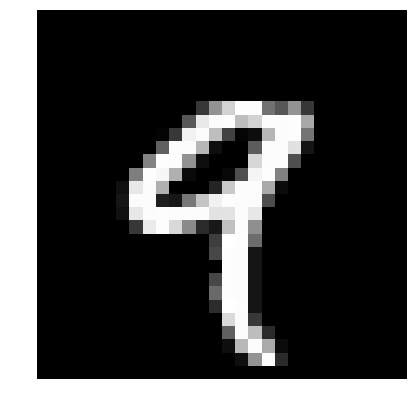

In [14]:
plt.set_cmap('gray')
plt.imshow(np.reshape(image,[28,28]))
plt.axis('off')

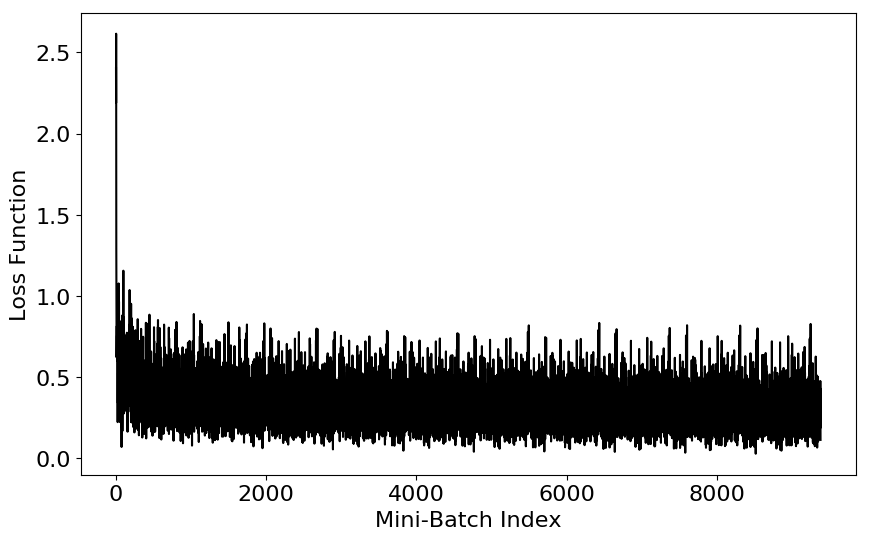

In [15]:
fig = plt.figure (figsize = (10,6))
plt.plot(np.arange(0,len(loss_history)),loss_history, label = "Loss Function", color = 'black')

plt.xlabel ('Mini-Batch Index', fontsize = 16)
plt.ylabel ('Loss Function', fontsize = 16)
plt.tick_params(axis='both', which='major', labelsize=16)

# MNIST with GPU acceleration

In [16]:
print(tf.test.is_gpu_available())

True


In [17]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found. Check the notebook settings.')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)


The following code have tensorflow operations that are placed on a GPU. At the moment the argmax has a bug and therefore has been placed on a CPU. A GPU make the code much faster than when using only a CPU (check above for the CPU only version)

In [19]:
%%time

for i in range(10): # Loop for the Epochs
  print ("\nEpoch:", i)
  
  for (batch, (images, labels)) in enumerate(dataset.take(60000)): # Loop for the mini-batches
    if batch % 100 == 0:
      print('.', end='')
    labels = tf.cast(labels, dtype = tf.int64)
    
    
    with tf.GradientTape() as tape:
      
      with tf.device('/gpu:0'):    
        logits = mnist_model(images, training=True)

      with tf.device('/cpu:0'):
        tgmax = tf.argmax(labels, axis = 1, output_type=tf.int64)
        
      with tf.device('/gpu:0'):  
        loss_value = tf.losses.sparse_softmax_cross_entropy(tgmax, logits)

        loss_history.append(loss_value.numpy())
        grads = tape.gradient(loss_value, mnist_model.variables)
        optimizer.apply_gradients(zip(grads, mnist_model.variables),
                                    global_step=tf.train.get_or_create_global_step())


Epoch: 0
..........
Epoch: 1
..........
Epoch: 2
..........
Epoch: 3
..........
Epoch: 4
..........
Epoch: 5
..........
Epoch: 6
..........
Epoch: 7
..........
Epoch: 8
..........
Epoch: 9
..........CPU times: user 1min 25s, sys: 3.41 s, total: 1min 28s
Wall time: 1min 26s
